# Project on Stroke Prediction

## Machine Learning Workflow

Although the exact implementation details can vary, the general structure of a machine learning project stays relatively constant:

    1) Data cleaning and formatting
    2) Exploratory data analysis
    3) Feature engineering and selection
    4) Establish a baseline and compare several machine learning models on a performance metric
    5) Perform hyperparameter tuning on the best model to optimize it for the problem
    6) Evaluate the best model on the testing set
    7) Interpret the model results to the extent possible
    8) Draw conclusions and write a well-documented report

# Import
We will use the standard data science and machine learning libraries: numpy, pandas, and scikit-learn. We also use matplotlib and seaborn for visualization.

In [1]:
# Pandas and numpy for data manipulation
import pandas as pd
import numpy as np

# No warnings about setting value on copy of slice, i.e. no annoying pink boxes
pd.options.mode.chained_assignment = None

# Display up to 60 columns of a dataframe
pd.set_option('display.max_columns', 60)

# Matplotlib visualization
import matplotlib.pyplot as plt
%matplotlib inline

# Set default font size
plt.rcParams['font.size'] = 24

# Internal ipython tool for setting figure size
from IPython.core.pylabtools import figsize

# Seaborn for visualization
import seaborn as sns
sns.set(font_scale = 2)

# Splitting data into training and testing
from sklearn.model_selection import train_test_split

# Data Cleaning and Formatting

## Load in the Data and Examine

We will be loading our data into a pandas dataframe, one of the most useful data structures for data science. Think of it as a spreadsheet within Python that we can easily manipulate, clean, and visualize. [Pandas has many methods](http://pandas.pydata.org/pandas-docs/stable/) to help make the data science/machine learning pipeline as smooth as possible.

In [2]:
# Read in data into a dataframe 
train_df = pd.read_csv('train_2v.csv')
test_df = pd.read_csv('test_2v.csv')

# Because data is huge, for purpose of practice, will reduce it to 20% sample of the whole population for the time being.
train_df = train_df.sample(frac=0.6, replace=True)

# Display top of dataframe
train_df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
37291,16076,Female,65.0,0,0,Yes,Govt_job,Rural,107.02,46.5,never smoked,0
18047,28696,Male,29.0,0,0,No,Private,Urban,113.87,31.8,never smoked,0
8286,27772,Female,57.0,0,0,Yes,Private,Urban,95.18,23.9,NaN,0
4390,56600,Female,43.0,0,0,Yes,Private,Rural,84.04,30.6,NaN,0
31107,32112,Female,66.0,0,0,No,Self-employed,Rural,97.03,22.4,never smoked,0


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 37291 to 42051
Data columns (total 12 columns):
id                   26040 non-null int64
gender               26040 non-null object
age                  26040 non-null float64
hypertension         26040 non-null int64
heart_disease        26040 non-null int64
ever_married         26040 non-null object
work_type            26040 non-null object
Residence_type       26040 non-null object
avg_glucose_level    26040 non-null float64
bmi                  25182 non-null float64
smoking_status       18077 non-null object
stroke               26040 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 2.6+ MB


Let's take a look to see if there are missing data in this dataframe set for Stroke

In [4]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [5]:
missing_values_table(train_df)

Your selected dataframe has 12 columns.
There are 2 columns that have missing values.


,Missing Values,% of Total Values
smoking_status,7963,30.6
bmi,858,3.3


# Exploratory Data Analysis

In [6]:
train_df_stroke = train_df.loc[train_df['stroke'] == 1]
sns.set(style="ticks")

In [7]:
numerical = [
  'age', 'bmi', 'avg_glucose_level'
]
categorical = [
  'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'
]

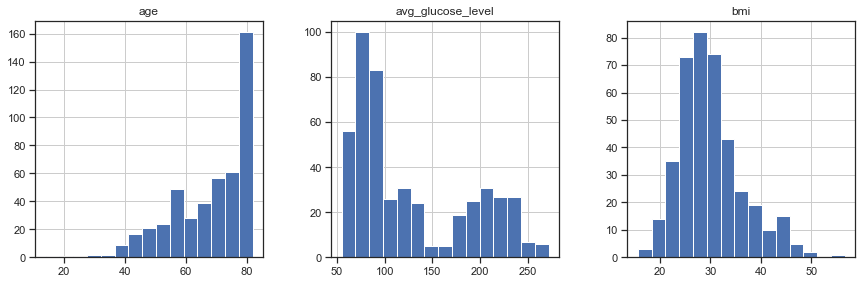

In [8]:
train_df_stroke[numerical].hist(bins=15, figsize=(20, 10), layout=(2, 4));

For the numerical data columns theres a few deductions can make by looking at the counts.
1. Chances of stroke is higher for people reaching the age of late 70s to their 80s.
2. Number of people with stroke is higher for those who seem to have average glucose level that is within the [permitted range](https://www.webmd.com/diabetes/qa/what-are-normal-blood-sugar-levels). 
3. Those whose BMI were at the higher end of 20s seem to be more susceptible to getting stroke.

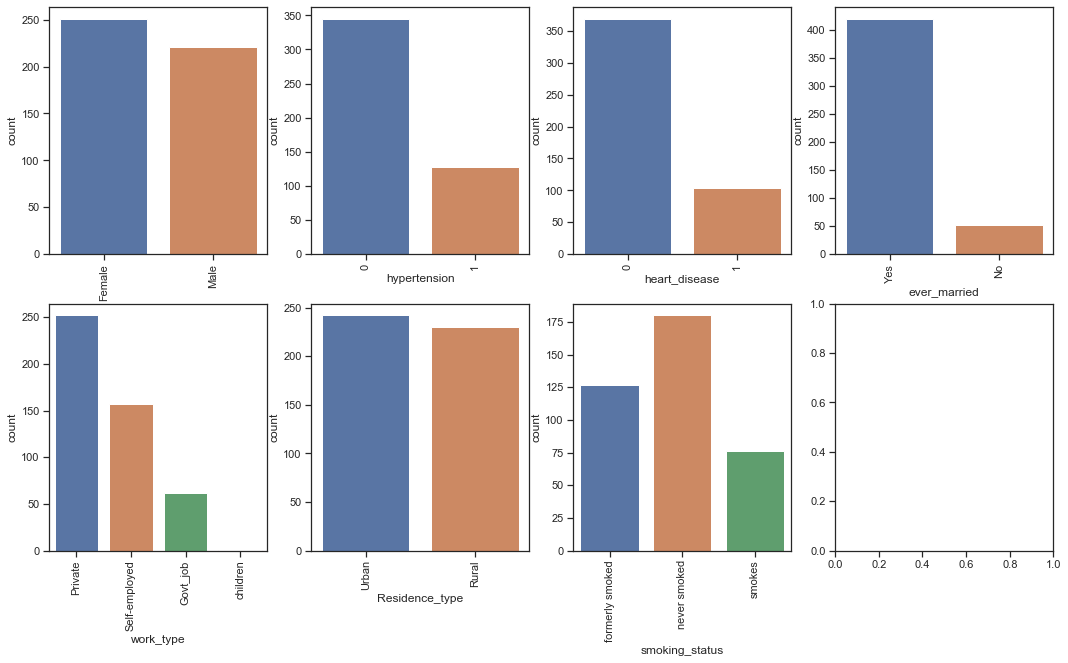

In [9]:
fig, ax = plt.subplots(2, 4, figsize=(18, 10))
for variable, subplot in zip(categorical, ax.flatten()):
    sns.countplot(train_df_stroke[variable], ax=subplot)
    for label in subplot.get_xticklabels():
        label.set_rotation(90)

If we look at the count of victims with stroke for each feature, the likely stroke victim seems to be one who is Female, Urban, Private, never smoke, married. Each of this feature seems to have an impact on the prediction one whether the person may have stroke. So lets take a look at each of them further. We begin by during a quantitative and categorical summary anaysis for the features.

In [10]:
def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

In [11]:
def categorical_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', verbose=True):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.countplot(x=x, y=y, hue=hue, data=dataframe, palette=palette)
    plt.show()


In [12]:
c_palette = ['tab:blue', 'tab:orange']

count    472.000000
mean      67.978814
std       12.619012
min       14.000000
25%       59.000000
50%       71.000000
75%       79.000000
max       82.000000
Name: age, dtype: float64
mode:  0    79.0
dtype: float64


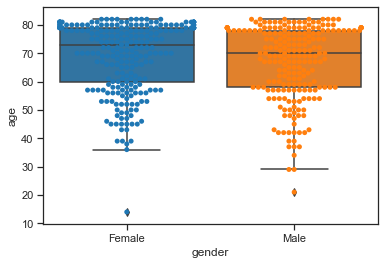

In [13]:
#Bivariate Analysis with target variable
quantitative_summarized(dataframe= train_df_stroke, y = 'age', x = 'gender', palette=c_palette, verbose=False, swarm=True)

From the data we can see that the average age of people who get stroke seem to be in their late 60s to 70s for both Males & Females. Females were likely to be a stroke victim at an older age among the 2 genders.

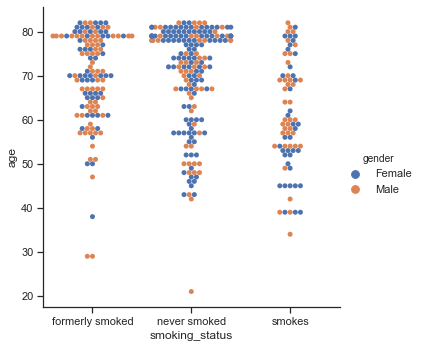

In [14]:
sns.catplot(x="smoking_status", y="age", hue="gender", kind="swarm", data=train_df_stroke);

count    472.000000
mean      67.978814
std       12.619012
min       14.000000
25%       59.000000
50%       71.000000
75%       79.000000
max       82.000000
Name: age, dtype: float64
mode:  0    79.0
dtype: float64


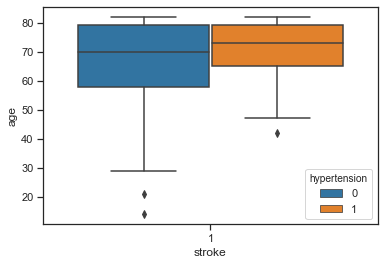

In [15]:
# multivariate analysis with Embarked variable and Pclass variable
quantitative_summarized(dataframe= train_df_stroke, y = 'age', x = 'stroke', hue = 'hypertension', palette=c_palette, verbose=False, swarm=False)


In [16]:
train_df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
37291,16076,Female,65.0,0,0,Yes,Govt_job,Rural,107.02,46.5,never smoked,0
18047,28696,Male,29.0,0,0,No,Private,Urban,113.87,31.8,never smoked,0


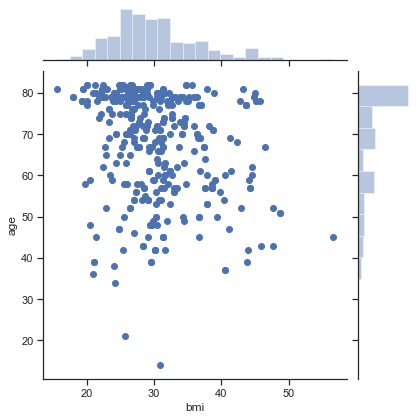

In [17]:
sns.jointplot(x=train_df_stroke['bmi'], y=train_df_stroke['age']);

In [18]:
train_df.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
37291,16076,Female,65.0,0,0,Yes,Govt_job,Rural,107.02,46.5,never smoked,0
18047,28696,Male,29.0,0,0,No,Private,Urban,113.87,31.8,never smoked,0



## Remove Collinear Features

Highly [collinear features](http://psychologicalstatistics.blogspot.com/2013/11/multicollinearity-and-collinearity-in.html) have a significant correlation coefficent between them. Thus, to opmitimize our models, we should look to remove any of the collinear features. 

In [19]:
def remove_collinear_features(x, threshold):
    '''
    Objective:
        Remove collinear features in a dataframe with a correlation coefficient
        greater than the threshold. Removing collinear features can help a model
        to generalize and improves the interpretability of the model.
        
    Inputs: 
        threshold: any features with correlations greater than this value are removed
    
    Output: 
        dataframe that contains only the non-highly-collinear features
    '''
    
    # Dont want to remove correlations between Score
    y = x['stroke']
    x = x.drop(columns = ['stroke'])
    
    # Calculate the correlation matrix
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []
    
    # Iterate through the correlation matrix and compare correlations
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # If correlation exceeds the threshold
            if val >= threshold:
                # Print the correlated features and the correlation value
                # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])

    # Drop one of each pair of correlated columns
    drops = set(drop_cols)
    x = x.drop(columns = drops)

    
    # Add the score back in to the data
    x['stroke'] = y
               
    return x

In [20]:
# Remove the collinear features above a specified correlation coefficient
train_df = remove_collinear_features(train_df, 0.6);

In [22]:
# Remove any columns with all na values
train_df  = train_df.dropna(axis=1, how = 'all')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26040 entries, 37291 to 42051
Data columns (total 12 columns):
id                   26040 non-null int64
gender               26040 non-null object
age                  26040 non-null float64
hypertension         26040 non-null int64
heart_disease        26040 non-null int64
ever_married         26040 non-null object
work_type            26040 non-null object
Residence_type       26040 non-null object
avg_glucose_level    26040 non-null float64
bmi                  25182 non-null float64
smoking_status       18077 non-null object
stroke               26040 non-null int64
dtypes: float64(3), int64(4), object(5)
memory usage: 2.6+ MB


# Machine Learning Modeling

Once feature engineering/construction is done, we can get started with the machine learning! All of our data (both training and testing) is aggregated for each household and so can be directly used in a model. To first show the process of modeling, we'll use the capable Random Forest Classifier in Scikit-Learn. This probably won't get us to the top of the leaderboard, but it will allow us to establish a baseline. Later we'll try several other models including the powerful Gradient Boosting Machine.

To assess our model, we'll use 10-fold cross validation on the training data. This will essentially _train and test the model 10 times_ using different splits of the training data. 10-fold cross validation is an effective method for estimating the performance of a model on the test set. We want to look at the average performance in cross validation as well as the standard deviation to see how much scores change between the folds. We use the `F1 Macro` measure to evaluate performance.

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

# Custom scorer for cross validation
scorer = make_scorer(f1_score, greater_is_better=True, average = 'macro')

In [24]:
features = list(train_df.columns)

pipeline = Pipeline([('imputer', Imputer(strategy = 'median')), 
                      ('scaler', MinMaxScaler())])

# Fit and transform training data
train_features = pipeline.fit_transform(train_features)
test_features = pipeline.transform(test_features)

C:\Users\Ismahfaris\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


NameError: name 'train_features' is not defined

In [ ]:
model = RandomForestClassifier(n_estimators=100, random_state=10, 
                               n_jobs = -1)
# 10 fold cross validation
cv_score = cross_val_score(model, train_features, train_labels.values.ravel(), cv = 10, scoring = scorer)

print(f'10 Fold Cross Validation Score = {round(cv_score.mean(), 4)} with std = {round(cv_score.std(), 4)}')

In [ ]:
model.fit(train_features, train_labels.values.ravel())

# Feature importances into a dataframe
feature_importances = pd.DataFrame({'feature': features, 'importance': model.feature_importances_})
feature_importances.head()

In [ ]:
def plot_feature_importances(df, n = 10, threshold = None):
    """Plots n most important features. Also plots the cumulative importance if
    threshold is specified and prints the number of features needed to reach threshold cumulative importance.
    Intended for use with any tree-based feature importances. 
    
    Args:
        df (dataframe): Dataframe of feature importances. Columns must be "feature" and "importance".
    
        n (int): Number of most important features to plot. Default is 15.
    
        threshold (float): Threshold for cumulative importance plot. If not provided, no plot is made. Default is None.
        
    Returns:
        df (dataframe): Dataframe ordered by feature importances with a normalized column (sums to 1) 
                        and a cumulative importance column
    
    Note:
    
        * Normalization in this case means sums to 1. 
        * Cumulative importance is calculated by summing features from most to least important
        * A threshold of 0.9 will show the most important features needed to reach 90% of cumulative importance
    
    """
    plt.style.use('fivethirtyeight')
    
    # Sort features with most important at the head
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # Normalize the feature importances to add up to one and calculate cumulative importance
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    
    # Bar plot of n most important features
    df.loc[:n, :].plot.barh(y = 'importance_normalized', 
                            x = 'feature', color = 'darkgreen', 
                            edgecolor = 'k', figsize = (12, 8),
                            legend = False, linewidth = 2)

    plt.xlabel('Normalized Importance', size = 18); plt.ylabel(''); 
    plt.title(f'{n} Most Important Features', size = 18)
    plt.gca().invert_yaxis()
    
    
    if threshold:
        # Cumulative importance plot
        plt.figure(figsize = (8, 6))
        plt.plot(list(range(len(df))), df['cumulative_importance'], 'b-')
        plt.xlabel('Number of Features', size = 16); plt.ylabel('Cumulative Importance', size = 16); 
        plt.title('Cumulative Feature Importance', size = 18);
        
        # Number of features needed for threshold cumulative importance
        # This is the index (will need to add 1 for the actual number)
        importance_index = np.min(np.where(df['cumulative_importance'] > threshold))
        
        # Add vertical line to plot
        plt.vlines(importance_index + 1, ymin = 0, ymax = 1.05, linestyles = '--', colors = 'red')
        plt.show();
        
        print('{} features required for {:.0f}% of cumulative importance.'.format(importance_index + 1, 
                                                                                  100 * threshold))
    
    return df

In [ ]:
norm_fi = plot_feature_importances(feature_importances, threshold=0.95)